In [173]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
# HSC Params
# l = 121.2
# b = -21.6
ti = 0.07
tf = 3
from LensCalcPy.parameters import *

In [175]:
s = Survey(l, b, ds, obsTime, survey_area=survey_area, n_sources=n_sources)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, survey_area=0)

In [176]:
t_es = np.logspace(-2, 1, 20) #hours

In [177]:
alpha = 2
s.add_ffp(alpha)
diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=False)

In [178]:
diff_rates_finite = s.get_crossing_times_rates_ffp(t_es, finite=True)

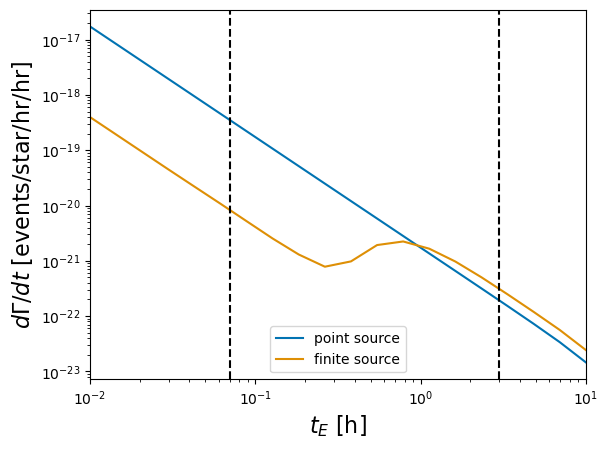

In [179]:
plt.loglog(t_es, diff_rates, label='point source')
plt.loglog(t_es, diff_rates_finite, label='finite source')

# Add lines for HSC sensitivity window
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
# plt.ylim(1e-16,1e-7)
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.legend()
plt.show()

In [180]:
diff_rate_interp = interp1d(t_es, diff_rates)

In [181]:
dnds = quad(diff_rate_interp, ti, tf)[0]

In [99]:
s.n_sources*efficiency*dnds

1.0334997362957063e-11

In [183]:
def get_n_events(A, alpha=2, finite=False):
    #Now A is number of FFPs per star
    s.add_ffp(alpha)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime*A

def get_n_events_parallel(As, alpha=2, finite=False):
    with Pool() as p:
        f = functools.partial(get_n_events, alpha=alpha, finite=finite)
        results = list(p.imap(f, As))
    return results

In [184]:
n_events = get_n_events(1, alpha=alpha, finite=False)

In [185]:
n_events_finite = get_n_events(1, alpha=alpha, finite=True)

In [186]:
#new
print(n_events)
print(n_events_finite)

9.366213403699055e-12
1.254262510334044e-12


## 2D exclusion plots

In [187]:
A_min = 1
A_max = 1e8
alpha_min = 1.1
alpha_max = 2.5
num_points = 20
A_values = np.logspace(np.log10(A_min), np.log10(A_max), num_points)
alpha_values = np.linspace(alpha_min, alpha_max, num_points) 
A_grid, alpha_grid = np.meshgrid(A_values, alpha_values)


In [ ]:
get_n_events_values = np.empty_like(A_grid)

for i in tqdm(range(len(alpha_values))):
    get_n_events_values[i] = get_n_events_parallel(A_values, alpha=alpha_values[i], finite=False)

In [148]:
get_n_events_values_finite = np.empty_like(A_grid)

for i in tqdm(range(len(alpha_values))):
    get_n_events_values_finite[i] = get_n_events_parallel(A_values, alpha=alpha_values[i], finite=True)

100%|██████████| 20/20 [57:34<00:00, 172.72s/it] 


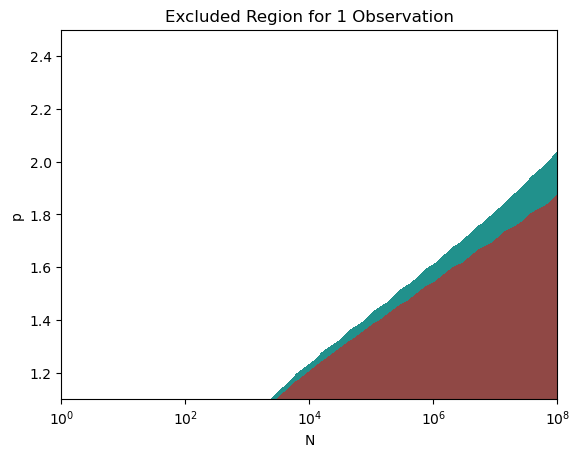

In [150]:
plt.figure()
contour = plt.contourf(A_grid, alpha_grid, get_n_events_values, levels=[4.74, 1e10])
plt.contourf(A_grid, alpha_grid, get_n_events_values_finite, levels=[4.74, 1e10], colors="red", alpha=0.5)
plt.xscale('log')
plt.title('Excluded Region for 1 Observation')
plt.xlabel('N')
plt.ylabel('p')
plt.show()

In [188]:
def get_constraint_iso(m_iso, alpha=2, finite=False):
    if m_iso < 1e-15:
        raise ValueError('Mass must be greater than 1e-15')
    
    #Number of total events assuming 1 ISO per star
    #Note A doesn't matter for this part of the calculation
    n_events = get_n_events(1, alpha=alpha, finite=finite)
    s.add_ffp(alpha)

    #Porportion of ISOs above threshold
    proportion_above_threshold = nquad(s.ffp.mass_func,[[m_iso, s.ffp.m_max]], opts={'points': [s.ffp.m_min, s.ffp.m_min*1e3, s.ffp.m_min*1e5]})[0]*s.ffp.Z

    #Maximum number of total allowed ISOs per star
    N_thresh = 4.74/n_events

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_thresh * proportion_above_threshold    

In [189]:
confidence_level_threshold = 0.05

Nexp = 1

# Calculate the cumulative probability until it exceeds the threshold
while True:
    # cumulative_prob = poisson.pmf(0, Nexp) + poisson.pmf(1, Nexp) 
    cumulative_prob = poisson.pmf(1, Nexp) 
    if cumulative_prob <= confidence_level_threshold:
        break
    Nexp += 0.01 

print(f"The 95% C.L. is reached when Nexp <= {Nexp}")

The 95% C.L. is reached when Nexp <= 4.499999999999948


### Constraints on local ISO Density

In [190]:
def get_n_events_pbh(m, finite=False):
    s.add_pbh(m)
    diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime

def get_constraint_fdm(m, finite=False):
    n_events = get_n_events_pbh(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1

In [9]:
#https://arxiv.org/pdf/1910.08608.pdf handwavy constraint in au^-3

local_dm_density = density_mw(dist_mw(0))
m_pbh = 1e-10
fpbh = get_constraint_fdm(m_pbh, finite=True)
kpc2au = 2.06e8

print("upper limit on number density of ISOs in au^-3 from HSC PBH constrint")
print(local_dm_density*kpc2au**(-3)*fpbh/m_pbh)

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


upper limit on number density of ISOs in au^-3 from HSC PBH constrint
2.919266497137061e-11


In [192]:
#Comparison with FFP distribution (new velocity dispersion)
local_stellar_density = rho_FFPs_mw(0)
m_iso = 1e-10
alpha = 1.83

#number of ISOs per star with mass greater than m_iso
n_objects = get_constraint_iso(m_iso, alpha=alpha, finite=True)

print("upper limit on number density of ISOs in au^-3 with mass greater than {} for alpha = {}".format(m_iso, alpha))
print(local_stellar_density*kpc2au**(-3)*n_objects)

upper limit on number density of ISOs in au^-3 with mass greater than 1e-10 for alpha = 1.83
6.405515385754012e-11


In [10]:
#Comparison with FFP distribution
local_stellar_density = rho_FFPs_mw(0)
m_iso = 1e-10
alpha = 1.83

#number of ISOs per star with mass greater than m_iso
n_objects = get_constraint_iso(m_iso, alpha=alpha, finite=True)

print("upper limit on number density of ISOs in au^-3 with mass greater than {} for alpha = {}".format(m_iso, alpha))
print(local_stellar_density*kpc2au**(-3)*n_objects)

upper limit on number density of ISOs in au^-3 with mass greater than 1e-10 for alpha = 1.83
5.975408561110705e-11


In [14]:
with Pool() as p:
    f = functools.partial(get_constraint_iso, m_iso, finite=True)
    n_objects_arr = list(tqdm(p.imap(f, alpha_values), total=len(alpha_values)))

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


100%|██████████| 20/20 [02:26<00:00,  7.31s/it]


In [53]:
loeb_alpha = 3.41
loeb_err = 0.17
loeb_p = loeb_alpha/3 + 1
loeb_p_err = loeb_err/3
loeb_n = 2.6e-14

dohanyi_alpha = 2.5
dohanyi_p = dohanyi_alpha/3 + 1
dohanyi_n = 7.2e-11

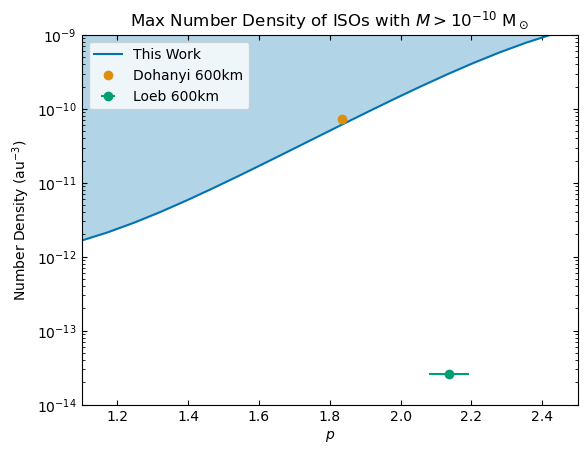

In [75]:
num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

plt.figure()

plt.plot(alpha_values, num_densities, label='This Work')
plt.fill_between(alpha_values, num_densities, np.max(num_densities), alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$p$')
plt.title(r'Max Number Density of ISOs with $M > 10^{-10}$ M$_\odot$')

plt.xlim([1.1, 2.5])
plt.ylim([1e-14, 1e-9])

plt.plot(dohanyi_p, dohanyi_n, 'o', label='Dohanyi 600km')
plt.errorbar(loeb_p, loeb_n, xerr=[loeb_p_err], fmt='o', label='Loeb 600km')

plt.legend()

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

plt.show()


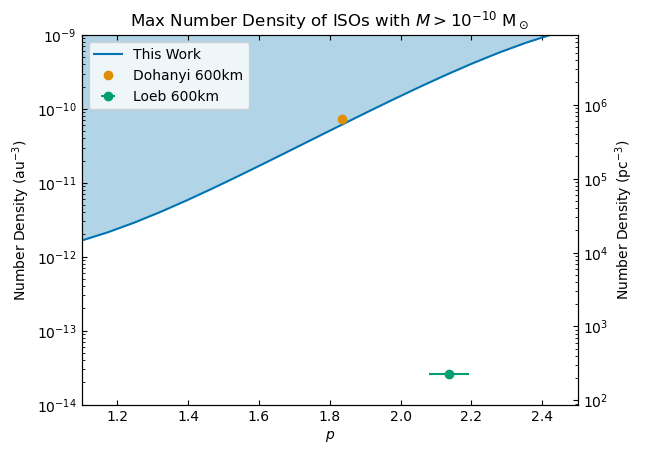

In [84]:
au3_to_pc3 = (4.85e-6)**3
num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

plt.figure()

plt.plot(alpha_values, num_densities, label='This Work')
plt.fill_between(alpha_values, num_densities, np.max(num_densities), alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$p$')
plt.title(r'Max Number Density of ISOs with $M > 10^{-10}$ M$_\odot$')

plt.xlim([1.1, 2.5])
plt.ylim([1e-14, 1e-9])

plt.plot(dohanyi_p, dohanyi_n, 'o', label='Dohanyi 600km')
plt.errorbar(loeb_p, loeb_n, xerr=[loeb_p_err], fmt='o', label='Loeb 600km')

plt.legend()

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([1e-14/au3_to_pc3, 1e-9/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

plt.show()


Now do for different ISO masses

In [86]:
m_arr = np.logspace(-12, -8, 3)
m_arr

array([1.e-12, 1.e-10, 1.e-08])

In [87]:
n_objects_dict = {}

In [126]:
for m in m_arr:
    with Pool() as p:
        f = functools.partial(get_constraint_iso, m, finite=True)
        n_objects_dict[m] = list(tqdm(p.imap(f, alpha_values), total=len(alpha_values)))

100%|██████████| 20/20 [02:34<00:00,  7.74s/it]


In [131]:
density = 2  # g/cm^3
msol_to_g = 1.99e33
diameters = {}

for m in m_arr:
    diameters[m] = (6*m*msol_to_g/(np.pi*density))**(1/3) * 1e-5 # diameter in km
diameters

{1e-12: 123.86296908321798,
 1e-10: 574.9209741947893,
 1e-08: 2668.5467740323147}

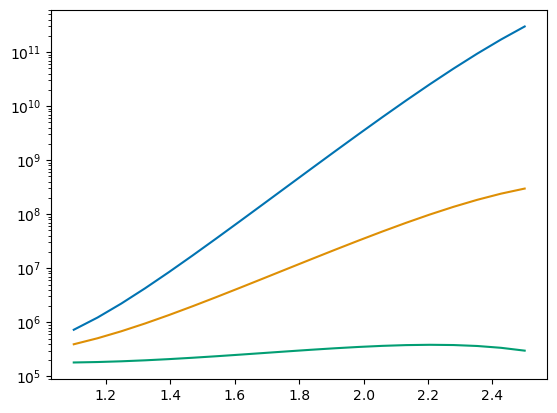

In [128]:
for mass, n_objects_arr in n_objects_dict.items():
    plt.plot(alpha_values, n_objects_arr, label='{} M$_\odot$'.format(mass))
plt.yscale('log')

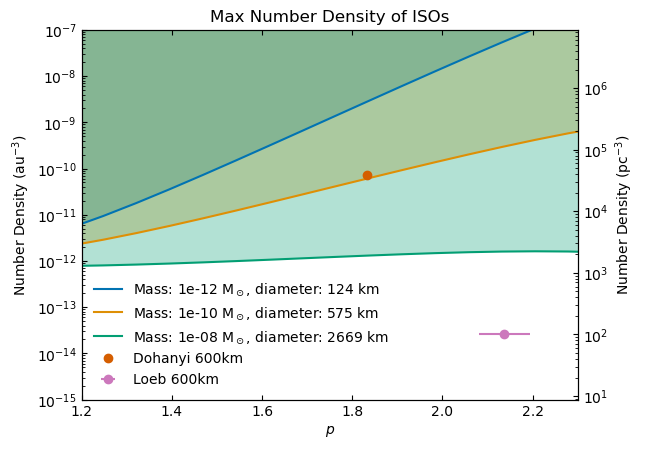

In [141]:
plt.figure()

# Loop over the dictionary items
for mass, n_objects_arr in n_objects_dict.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

    plt.plot(alpha_values, num_densities, label=f'Mass: {mass} M$_\odot$, diameter: {diameters[mass]:.0f} km')
    plt.fill_between(alpha_values, num_densities, 1e-5, alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$p$')
plt.title(r'Max Number Density of ISOs')

plt.xlim([1.2, 2.3])
plt.ylim([1e-15, 1e-7])

plt.plot(dohanyi_p, dohanyi_n, 'o', label='Dohanyi 600km')
plt.errorbar(loeb_p, loeb_n, xerr=[loeb_p_err], fmt='o', label='Loeb 600km')

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([1e-15/au3_to_pc3, 1e-9/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

plt.show()


### Now as a function of mass instead of alpha

In [157]:
m_values = np.logspace(-12, -8, 16)
alpha_values_mass = np.linspace(1.6, 2.4, 3)

In [158]:
n_objects_dict_mass = {}
for alpha in alpha_values_mass:
    with Pool() as p:
        f = functools.partial(get_constraint_iso, alpha=alpha, finite=True)
        n_objects_dict_mass[alpha] = list(tqdm(p.imap(f, m_values), total=len(m_values)))

100%|██████████| 16/16 [01:57<00:00,  7.37s/it]


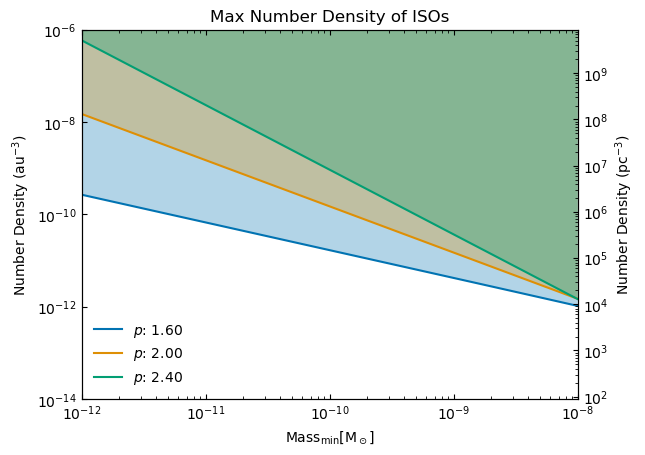

In [161]:
plt.figure()

# Loop over the dictionary items
for alpha, n_objects_arr in n_objects_dict_mass.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

    plt.plot(m_values, num_densities, label=f'$p$: {alpha:.2f}')
    plt.fill_between(m_values, num_densities, 1e-5, alpha=0.3)

plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$\rm{Mass_{min}} [ M_\odot ]$')
plt.title(r'Max Number Density of ISOs')

plt.xlim([1e-12, 1e-8])
plt.ylim([1e-14, 1e-6])

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([1e-14/au3_to_pc3, 1e-6/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

plt.show()


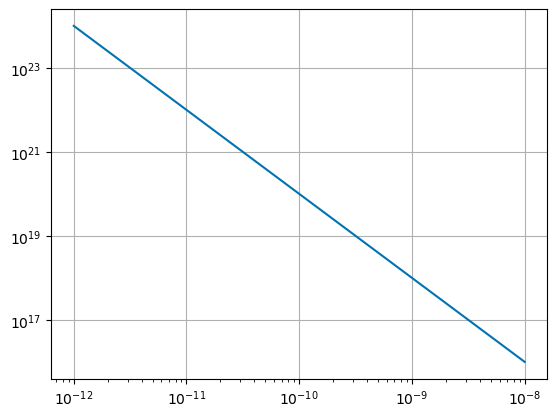

In [169]:
plt.loglog(m_arr,s.ffp.mass_func(m_arr))
plt.grid()
plt.show()

### Lightcurve of event

In [194]:
import pandas as pd

In [215]:
df = pd.read_csv('hsc_lightcurve.csv', header=None)
df.head()
lightcurve_interp = interp1d(df[0], df[1], kind='linear', bounds_error=False, fill_value=0)

In [246]:
#Calculate the full width half maximum of the light curve
def fwhm(time, flux):
    #find baseline flux
    baseline = np.median(flux)
    half_max = (np.max(flux) + baseline ) / 2
    #find when the flux array is above half_max
    indexes = np.where(flux > half_max)
    
    return time[indexes[0][-1]], time[indexes[0][0]]

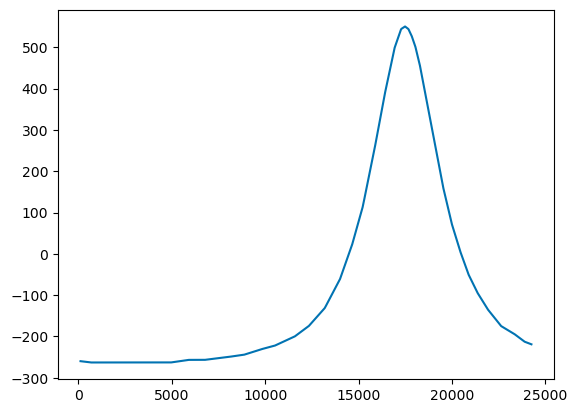

In [247]:
t_lightcurve = np.linspace(min(df[0]), max(df[0]), 1000)
counts_interp = lightcurve_interp(t_lightcurve)
plt.plot(t_lightcurve, counts_interp)
plt.show()

In [248]:
fwhm_max, fwhm_min = fwhm(t_lightcurve, counts_interp)

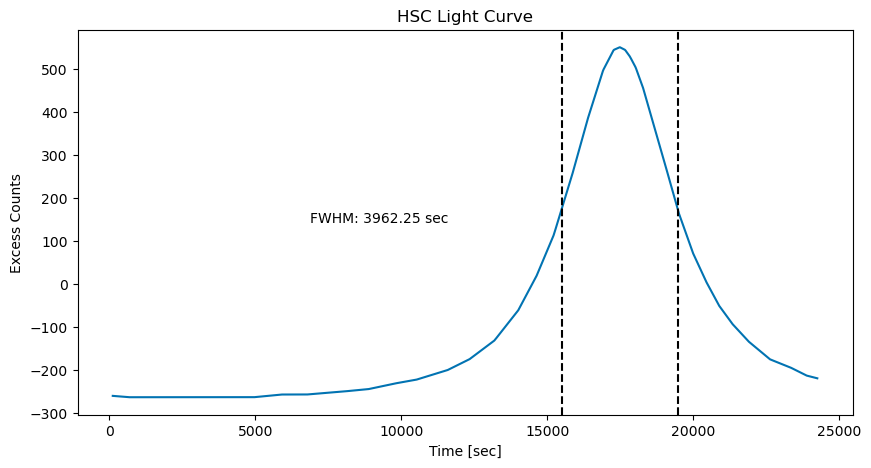

In [250]:
plt.figure(figsize=(10, 5))
plt.plot(t_lightcurve, counts_interp)
plt.xlabel('Time [sec]')
plt.ylabel('Excess Counts')
plt.axvline(fwhm_min, color='k', linestyle='--')
plt.axvline(fwhm_max, color='k', linestyle='--')
plt.title('HSC Light Curve')
plt.text(0.3, 0.5, f'FWHM: {fwhm_max-fwhm_min:.2f} sec', transform=plt.gca().transAxes)
# plt.savefig('figures/hsc_lightcurve.pdf')
plt.show()
